# Integration of Remote Sensing and Field data for Soil Moisture estimation in an irrigation scheme 

**Products used**: 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

Sentinel-1 Analysis Ready Data (ARD) data from the Digital Earth (DE) Africa data hub was used for the use case. Sythetic Aparture Radar’s ability to *see through* clouds makes it a critical dataset for mapping and monitoring land changes in the wet tropics. The dual polarisation backscatter time series can be used in applications for forests, agriculture, wetlands and land cover classification.

**Overview**

Welcome to this training session on Soil Moisture estimation in an irrigation scheme using the Digital Earth Africa (DE Africa) Sandbox. This training session builds on a case study for soil moisture estimation in the Botanga irrigation scheme in the Northern region of Ghana (Overview video is needed). 
The use case was co-developed with DIWASA stakeholders in Ghana to address the request from the Ghana Irrigation Development Authority (GIDA). The following experts were involved in the use case development with technical support from IWMI and DE Africa. 
* Ing. James Komla Ashaley (GIDA)
* Ing. Theophilus Kofitio (GIDA)
* Mrs. Mabel Kumah (IWMI)
* Dr. Benjamin Wullobayi Dekongmen (Ho Technical University)
* Ing Dr. Jacob Kofi Mensah (Tamale Technical University)

This work was further reinforced by the guidance and technical support of the International Water Management Institute (IWMI) team, particularly Dr. Alemseged Tamiru Haile, Dr. Seifu Tilahun, Dr. Jacob Aguekum and Dr. Eric Mortey, whose expertise ensured the scientific quality and successful completion of this initiative. We would also like to acknowledge DE Africa for providing the technical infrastructure, data access platform, and analytical environment (DE Africa sandbox) that made this use case possible.  

***

**Background**

Monitoring soil moisture (SM) is critical for sustainable agriculture, especially in water-scarce and climate-sensitive regions. Accurate, timely, and spatially detailed information on soil moisture supports effective decisions on irrigation scheduling, crop selection, drought risk management, and yield prediction. Traditional methods of soil moisture measurement are often limited by sparse sampling, cost, and labor intensity. Remote sensing, particularly Synthetic Aperture Radar (SAR) from Sentinel-1 satellites, offers an efficient and scalable alternative.
This training session focuses on deriving and validating soil moisture estimates using Sentinel-1 Synthetic Aperture Radar (SAR) data. The methodology leverages open-access datasets and cloud-based tools provided by  DE Africa, integrating them with a simple regression-based model and field observations to generate continuous soil moisture data for the period 2020–2024.
The geographic setting of the case study is on the Bontanga Irrigation Scheme (BIS). The BIS, located in Northern Ghana between latitudes 9°30′–9°35′ N and longitudes 1°20′–1°04′ W, covers 507 hectares with a potential irrigable area of 800 hectares. Commissioned in the late 1970s, the scheme relies on water from the Bontanga Dam, using both gravity and pump systems for irrigation. The scheme supports thirteen communities including Tibung, Kumbungu, Kpasogu, Dalun, Wuba, Kukuo, Saakuba, Yiplegu, Voggu, Kushibo, Zangbalwe, and Bagli in rice, maize and vegetable production (Abdul-Ganiyu et al., 2012). It has a distinct wet season from April to October. The major water management issue is inefficient water distribution, often due to poor canal maintenance and limited farmer coordination. Despite this, the scheme plays a vital role in regional food production. The scheme is managed by the GIDA. 

**Learning objectives**

In this session, you will learn how to:
- Load and preprocess Sentinel-1 SAR data.
- Apply speckle filtering using the Lee Filter.
- Map soil moisture distribution  in the irrigation scheme.
- Perform time series SM analysis.
- Derive coefficients for soil moisture estimation using a linear regression model.
- Visualize soil moisture data using line plots, scatter plots and maps.


**Addition**

$$
SM = a \times SMI + b
$$

**Normalized Difference**
$$
NSMI = \frac{\sigma^{VV} - \sigma^{VH}}{\sigma^{VV} + \sigma^{VH}}
$$

Where $ \sigma^{VV} $ and $ \sigma^{VH} $ are the backscatter coefficients for VV and VH polarizations, respectively.

**Sigma Method**

Alternatively, the *VV polarization* alone can be used as a proxy for soil moisture for areas with sparse vegetation:

$$
SMIv = \frac{\sigma^{VV} - \sigma_{\min}}{\sigma_{\max} - \sigma_{\min}}
$$

$$
\begin{aligned}
\sigma^{VV}  & : \quad VV  \text{ backscatter value for the current pixel} \\
\sigma_{\min} & : \quad \text{Minimum VV backscatter (dry conditions)} \\
\sigma_{\max} & : \quad \text{Maximum VV backscatter (wet conditions)}
\end{aligned}
$$
***

## Environment Setup

In this section you will sets up the Python environment, import libraries, and creating a Datacube instance. It includes packages for data handling, visualization, spatial analysis, and machine learning. These tools are essential for accessing, processing, and analyzing satellite data (seen below).


### Load packages
The following packages are required for this exercise 

In [1]:
import os # Import standard libraries 
import warnings 
import datacube # Import the Digital Earth Africa (DE Africa) datacube 
import pandas as pd # for handling tabular data 
import numpy as np # for numerical operations
import xarray as xr # for working with multi-dimensional datasets
import rioxarray as rxr # extends xarray to include geospatial raster data handling
import geopandas as gpd # for processing vector geospatial data
import matplotlib.pyplot as plt # for visualizing data
import statsmodels.api as sn # provides statistical models and tests 

DE Africa packages, custom functions

In [2]:
from datacube.utils.geometry import Geometry # Utility from the datacube to define geometries 
from deafrica_tools.spatial import xr_rasterize # DE Africa utility to convert vector geometries to raster format 
from deafrica_tools.datahandling import load_ard # loading Analysis Ready Data (ARD)
from deafrica_tools.plotting import display_map # DE Africa tools for visualization
from IPython.display import Image #  to display images directly in Jupyter Notebooks
from pyproj import Transformer

# Custom functions
from tools.soil_moisture_functions_o import lee_filter_xarray #lee filter
from tools.soil_moisture_functions_o import calculate_smi_ratio # NSMI Calculator 
from tools.soil_moisture_functions_o import calculate_smi_vv_only # SMI Calculator
# Ensures matplotlib plots are displayed inline in Jupyter Notebooks
%matplotlib inline 

warnings.filterwarnings("ignore")

### Connect to the datacube

Creates a new Datacube instance named **dc** for querying and loading satellite data \
The **app** name is a label used for logging and monitoring purposes (helpful when debugging)

In [3]:
dc = datacube.Datacube(app="Sentinel_1")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The area of interest must be defined with a shapefile (`.shp`), a geojosn (`.geojson`), or a KML file (`.kml`).

The parameters are:

* `time`: The time range including the start and end date of the analysis (`'2020-01-01', '2024-12-31'`)
* `product` : sentinel-1 is used for the analysis; acceptable value are `'s1_rtc'`
* `aoi`: The file path and name of a vector file containing the extent. Can be a `.kml` file, or a `.shp` file.
* `resolution`: `'10 m'` 

In [4]:
# Define the product name 

product = "s1_rtc"

# Load the Area of Interest (AOI) from a geojson specified using path
aoi = gpd.read_file("Data/Bontanga_Blocks.geojson")

#Output Filepath
filepath = "Results"

# Backscatter Ploirization to load
Measurements = ['vv', 'vh']

# Define the parameters for analysis
time_range = ('2020-01-01', '2024-12-31')  
orbit_direction = 'ascending' # Ascending often gives better consistency in viewing geometry 
resolution = (-10,10) # Sets the spatial resolution 

### Visualizing area of interest

Visualising the AOI simply means plotting or displaying that AOI on a map to show the spatial extent (shapefile) that defines where you want to conduct your analysis or extract data.

In [5]:
# Use `explore()` to visualize the AOI of the map
aoi.explore() 

### Load data for parameters set

This code uses the `load_ard` utility from Digital Earth Africa (DE Africa) to load Sentinel-1 Analysis Ready Data (ARD) for a specified area and time range. It retrieves radar backscatter measurements (`vv` and `vh` polarizations) from the `s1_rtc`, within the geographic bounds of an area of interest (aoi) and over a defined `time_range` 

The data is reprojected to the UTM Zone 30N coordinate system `EPSG:32630`, and is loaded at a specified spatial `resolution`. Observations are grouped by solar day to reduce redundancy, and data types are preserved in their original format, `dtype`.

In [6]:
# Load the Sentinel-1 Analysis Ready Data (ARD) using DE Africa's load_ard utility

S1 = load_ard(dc=dc, # The initialized datacube instance used to query the data
              products = product, # Product to load 
              measurements = Measurements, # Backscatter polarizations to load (VV and VH)
              x = (aoi.total_bounds[0], aoi.total_bounds[2]), 
              y = (aoi.total_bounds[1],aoi.total_bounds[3]), 
              time = time_range, # Period of study 
              output_crs = "EPSG:32630", # coordinate reference system (CRS) 
              resolution = resolution, # Spatial resolution 
              group_by = "solar_day", # Groups observations by day 
              dtype = 'native' # native format of data 
             )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 209 time steps


### Visualization of bands

To quickly view the loaded data bands, select specific time indices from the loaded Sentinel-1 data to visualize (e.g., 3rd, 13th, and 37th image)

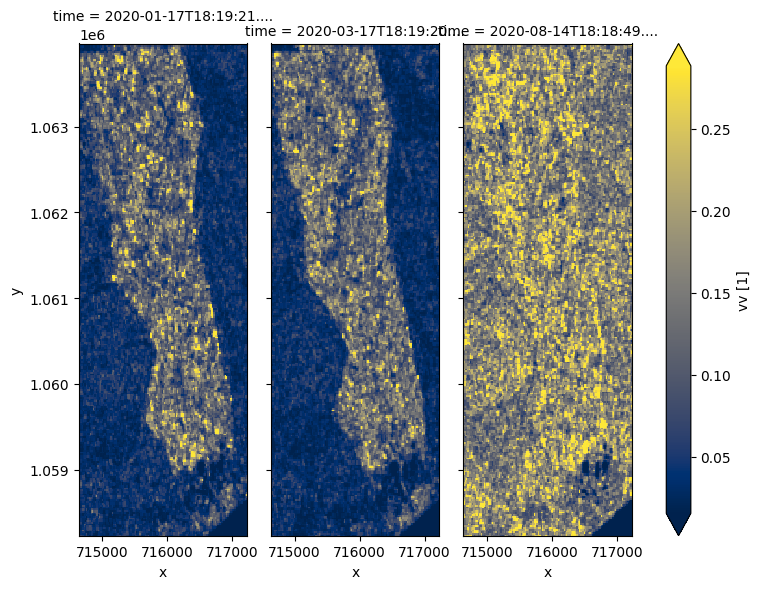

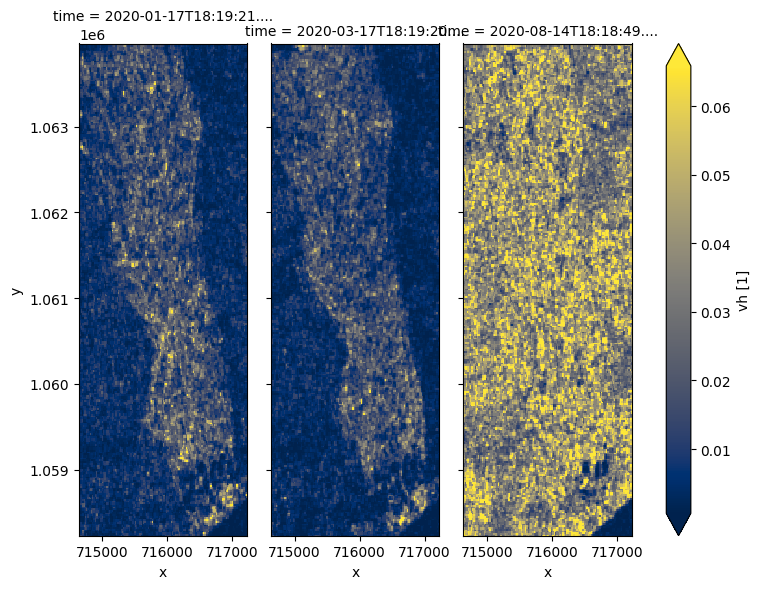

In [7]:
timesteps = [2,12,36] # select the 3rd, 13th and 37th image

# Plot the VV polarization for the selected time steps 

# the isel funtion is used to select a specific time, data within the data frame
S1.vv.isel(time=timesteps).plot(cmap="cividis", robust=True, 
                                col="time", col_wrap=3, figsize=(8, 6));

        # Similarly, plot the VH polarization for the same time steps
S1.vh.isel(time=timesteps).plot(cmap="cividis", robust=True, 
                                col="time", col_wrap=3, figsize=(8, 6));

### Apply Lee speckle filtering

The Lee Speckle Filter is a noise reduction technique commonly used in SAR imagery. It specifically targets and reduces speckle noise, which is not random noise, but rather a multiplicative interference of backscattered radar signals from multiple scatterers within a single pixel. 

In [8]:
# Apply the Lee filter to both VV and VH bands and store the results as new variables
S1['vv_filtered'] = lee_filter_xarray(S1['vv'], kernel_size=3)
S1['vh_filtered'] = lee_filter_xarray(S1['vh'], kernel_size=3)

### Visualized Filtered bands

A quick display of filtered bands 
These are arbitrary indices in the time dimension (e.g., 11th, 25th, and 31st image)

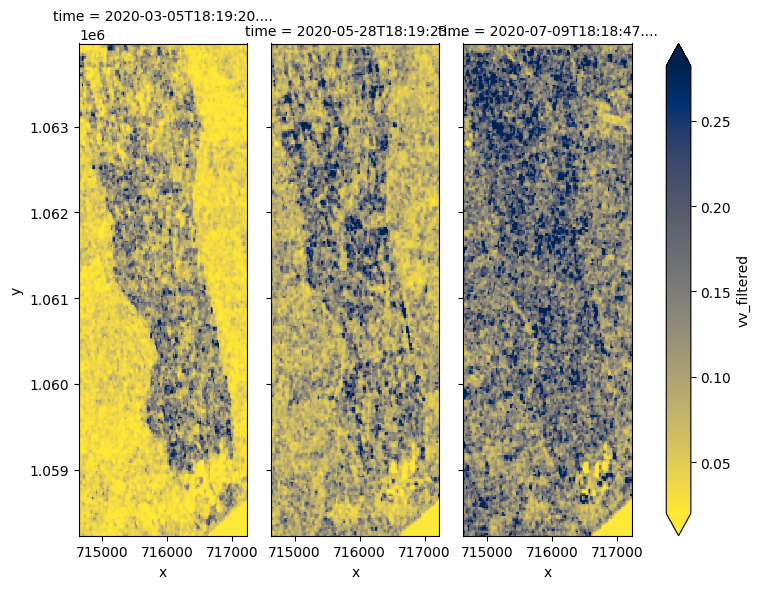

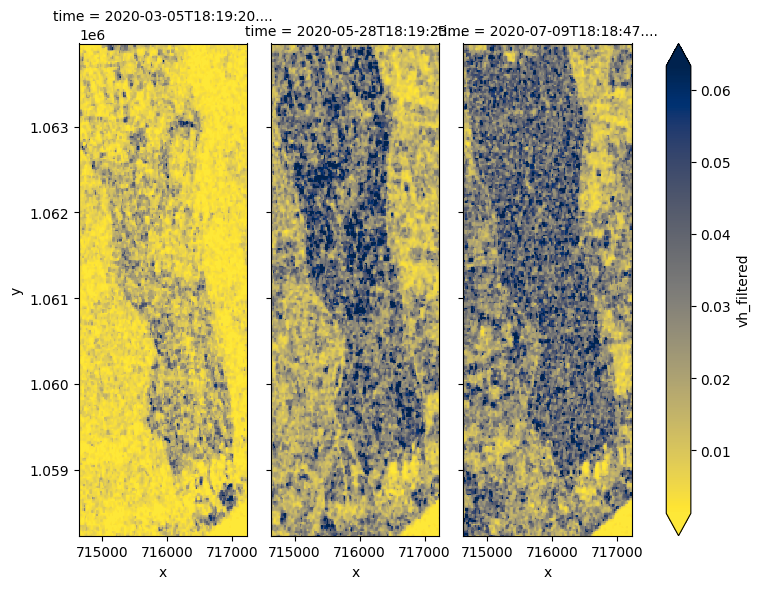

In [9]:
timesteps = [10, 24, 30] # Select specific time indices

        # Plot the filtered VV polarization for the selected timesteps 
S1.vv_filtered.isel(time=timesteps).plot(cmap="cividis_r", 
                                         robust=True, col="time", col_wrap=3, 
                                         figsize=(8, 6))

        # Plot the filtered VH polarization for the same timesteps
S1.vh_filtered.isel(time=timesteps).plot(cmap="cividis_r", 
                                         robust=True, col="time", col_wrap=3, 
                                         figsize=(8, 6))

### Calculate Soil Moisture Index Using Normalised difference and the sigma method

#### Calculate Soil Moisture Index Using Normalised difference (NSMI)

This is calculated  using the first formula (ratio of VV and VH)
$$
NSMI = \frac{\sigma^{VV} - \sigma^{VH}}{\sigma^{VV} + \sigma^{VH}}
$$


In [10]:
# Calls the function to compute the ratio-based SMI (VV - VH) / (VV + VH)
NSMI = calculate_smi_ratio(S1) 

# Add the result to the dataset 
S1['NSMI'] = NSMI

#### Calculate Soil Moisture Index VV only 

$$
SMI = \frac{\sigma^{VV} - \sigma_{\min}}{\sigma_{\max} - \sigma_{\min}}
$$


In [11]:
# Extract the minimum and maximum sigma values of VV
sigma_min = S1.vv_filtered.min().values  # minimum VV backscatter (dry conditions)
sigma_max = S1.vv_filtered.max().values  # maximum VV backscatter (wet conditions)

# Calculate SMI using the VV polarization alone as a proxy
SMIv = calculate_smi_vv_only(S1, sigma_min, sigma_max)

# Add the calculated SMIv (Normalized Soil Moisture Index) to the dataset
S1['SMIv'] = SMIv

### Masking and Visualize NSMI and SMIv for AOI

In order to mask, first, reproject the area of interest (AOI) to match the coordinate reference system (CRS) of the Sentinel-1 dataset. Second, rasterize the AOI to create a mask (1 for areas inside the AOI, 0 for outside), and then apply the mask to the Sentinel-1 dataset (S1)

In [12]:
# This ensures that both the AOI and the Sentinel-1 data align spatially
aoi = aoi.to_crs(S1.rio.crs) # if aoi and satellite data have different CRS

# Rasterize the AOI to matching the spatial resolution of the Sentinel-1 data
# converts the vector AOI boundary into a raster using xr_rasterize, 
mask = xr_rasterize(aoi, S1)

# Apply the mask to the Sentinel-1 dataset (S1)
# This will set values outside the AOI to NaN by using S1.where 
S1_mask = S1.where(mask)

To visualize NSMI and SMIv, for a specific date (e.g. December 9, 2024) select the two variables (NSMI and SMIv) from the masked dataset S2, and select the time **2024-12-09T18:19:41.092337000**

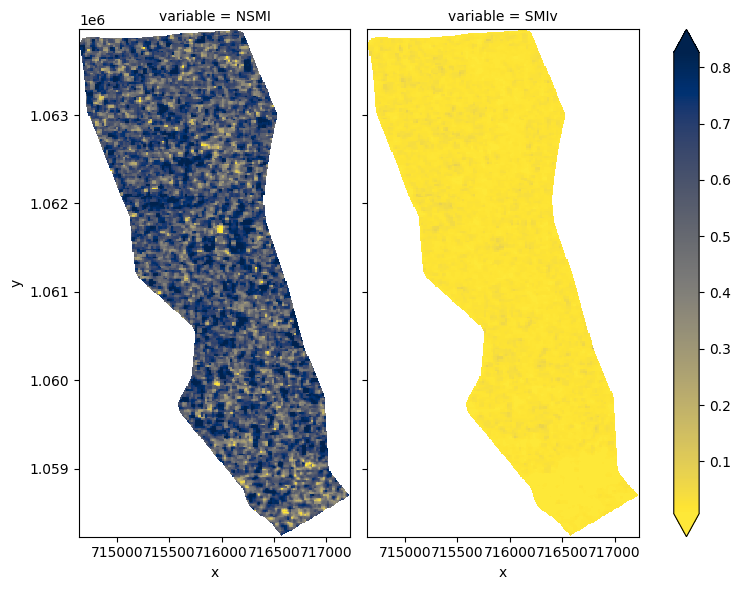

In [13]:
# Select the two variables (NSMI and SMIv) from the masked dataset S2 and plot for ecember 9, 2024
# 2024-12-09T18:19:41.092337000
S1_mask[['NSMI', 'SMIv']].sel(time="2024-12-09T18:19:41.092337000"
                        ).to_array().plot(cmap="cividis_r", 
                                          robust=True, col ="variable", 
                                          figsize=(8, 6))

### Time Series Analysis

To observe trends over time, this section computes and plots the temporal evolution of the soil moisture indices averaged over the AOI. First, the areal mean is computed for each index over the the AOI and the time series plotted.

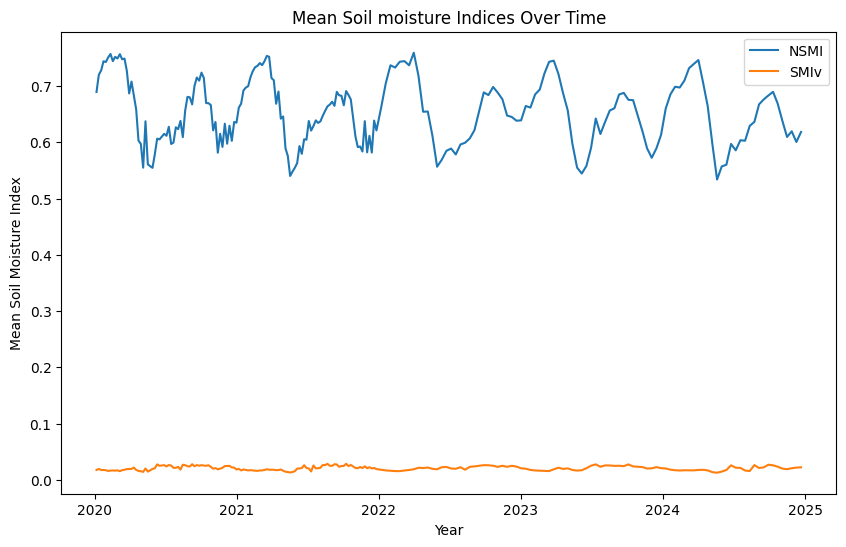

In [14]:
# This gives a single average value per time step (i.e., per image date)

plt.figure(figsize=(10,6)) # Figure Size 

# Compute the areal mean using .mean funcftion of the NSMI 
S1_mask['NSMI'].mean(dim=['x', 'y']).plot(label='NSMI')

# Compute the areal mean using .mean funcftion of the SMIv 
S1_mask['SMIv'].mean(dim=['x', 'y']).plot(label='SMIv')

# Plot 
plt.legend(loc='upper right')   # Add a legend to distinguish the two curves
plt.xlabel('Year')  # Label the x-axis 
plt.ylabel('Mean Soil Moisture Index')  # Label the y-axis )
plt.title('Mean Soil moisture Indices Over Time')  # Add a title to the plot
plt.show() # Display the final plot

**Monthly timeseries** 

This code processes the time-series dataset (`S2`) by aggregating it at monthly temporal scales, it resamples the data into **monthly means** (`S2_monthly`), averaging all values within each calendar month. 

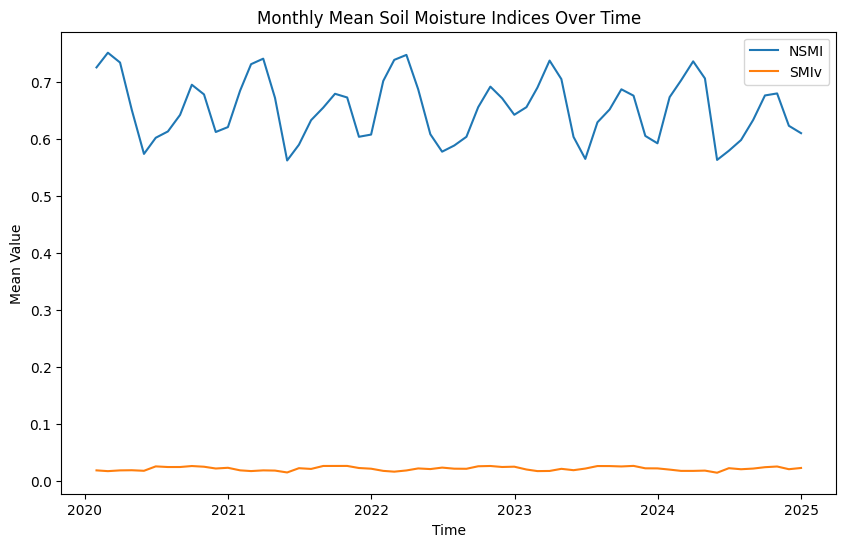

In [15]:
# Resample the dataset to monthly intervals ('1M') along the time dimension
S1_monthly = S1_mask.resample(time='1M').mean(dim='time')
#S2_monthly

# Compute and plot the mean values over spatial dimensions (x, y)
plt.figure(figsize=(10,6))

S1_monthly['NSMI'].mean(dim=['x', 'y']).plot(label='NSMI')
S1_monthly['SMIv'].mean(dim=['x', 'y']).plot(label='SMIv')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Mean Value')
plt.title('Monthly Mean Soil Moisture Indices Over Time')

# Display the plot
plt.show()

# Estimation of Soil Moisture 


In this section, you will estimate SM by establishing a relationship between the soil moisture indices (NSMI and SMIv) and observed SM . The observed SM (from a single gauge) data is monthly data obtained from  the Council for Scientific and Industrial Research, Savanna Agricultural Research Institute (CSIR-SARI), collected at a specific location in Nyankpala-Tamale, for a period from  2020-01-01 to 2022-07-07. 

To achieve exercise follow the steps  below:
- Resample the NSMI and SMIv datasets into monthly averages.
- Extract the NSMI and SMIv for the same time period and location as the observed SM.
- Import the observed SM data into a dataframe.

***
### Analysis parameters

The following cell sets the parameters, which define the area of interest for comparison, the length of time to conduct the analysis over.
The area of interest must be minmum longitude and maximum longitude; minmum latitude and maximum latititude. 

Observed data location 
Longitude = -1.2
Latitude = 9.5 

The parameters are:

* `time_range`: `'2020-01-01', '2022-07-05'`
* `product`: `'s1_rtc'`
* `aoi`: The longiude, latitude bound for area of observed dataset 
* `resolution`: `'10 m'`
* `Irrigation months`: Nov, Dec, Jan, Feb, Mar
* `Measurements` = `['vv', 'vh']`

## Data Preparation for the Soil Moisture model 

### Loading Sentinel 1 Data for observation data period

Load Sentinel 1 data using analysis parameters

In [16]:
# Define bounding box coordinates (in degrees)
min_lon, max_lon = -1.25, -1.15
min_lat, max_lat = 9.45, 9.55
time_range = ('2020-01-01', '2022-07-05')  

Measurements = ['vv', 'vh']

# Load Sentinel-1 ARD for the bounding box
S1 = load_ard(
    dc=dc,                           # Your initialized datacube instance
    products=product,                # Sentinel-1 product name
    measurements=Measurements,       # Polarizations to load
    x=(min_lon, max_lon),            # Longitude range
    y=(max_lat, min_lat),            # Latitude range (note: y is (max, min))
    time=time_range,                 # Time period of interest
    output_crs="EPSG:32630",         # Project to UTM Zone 30N
    resolution=resolution,           # Spatial resolution (e.g., 10)
    group_by="solar_day",            # Group scenes by solar day
    dtype='native'                   # Keep native data type
)


Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 136 time steps


### Apply Lee filter 

In [17]:
# Apply the Lee filter to both VV and VH bands and store the results as new variables
S1['vv_filtered'] = lee_filter_xarray(S1['vv'], kernel_size=3)
S1['vh_filtered'] = lee_filter_xarray(S1['vh'], kernel_size=3)

### Computing the NSMI and SMIv Indices

This code computes two soil moisture indices from Sentinel-1 data, NSMI using the VV–VH ratio, and SMIv using only the VV band, then adds them to the dataset S1 for analysis.


In [18]:
# Calls the function to compute the ratio-based SMI (VV - VH) / (VV + VH)
NSMI = calculate_smi_ratio(S1) 

# Add the result to the datafram 
S1['NSMI'] = NSMI


# Extract the minimum and maximum sigma values of VV to computer SMIv
sigma_min = S1.vv_filtered.min().values  # minimum VV backscatter (dry conditions)
sigma_max = S1.vv_filtered.max().values  # maximum VV backscatter (wet conditions)

# Calculate SMI using the VV polarization alone as a proxy
SMIv = calculate_smi_vv_only(S1, sigma_min, sigma_max)

# Add the calculated SMIv (Normalized Soil Moisture Index) to the dataset
S1['SMIv'] = SMIv

# View dataset
S1

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 136, y: 1113, x: 1105)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2020-01-05T18:19:21.943758 ... 202...
  * y            (y) float64 9kB 1.056e+06 1.056e+06 ... 1.045e+06 1.045e+06
  * x            (x) float64 9kB 6.921e+05 6.921e+05 ... 7.031e+05 7.031e+05
    spatial_ref  int32 4B 32630
Data variables:
    vv           (time, y, x) float32 669MB 0.06625 0.06342 ... 0.1456 0.1456
    vh           (time, y, x) float32 669MB 0.009363 0.009919 ... 0.02304
    vv_filtered  (time, y, x) float32 669MB 0.06534 0.06434 ... 0.1501 0.1456
    vh_filtered  (time, y, x) float32 669MB 0.009546 0.009736 ... 0.02304
    NSMI         (time, y, x) float32 669MB 0.7451 0.7371 ... 0.7405 0.7267
    SMIv         (time, y, x) float32 669MB 0.000913 0.0008989 ... 0.002045
Attributes:
    crs:           EPSG:32630
    grid_mapping:  spatial_ref

### Resample Satellite data into monthtly datasets and select irrigation months

This code resamples the dataset to monthly intervals, averaging all observations within each month.

In [19]:
# This code resamples the dataset to monthly intervals, 
# averaging all observations within each month.
S2_M = S1.resample(time='1M').mean(dim='time')

#irrigation Months 

irrigation_selected_months = [11, 12, 1, 2, 3]

### Extracting satellite-derived indices (NSMI, SMIv) for specific points
In this code, you will define the points to extract, tranform the points into the required CRS, extract both NSMI and SMIv for 2020-2022 using the nearest neighbour method

In [20]:
# Define the single geographic coordinate (in degrees, WGS84)
lon = -1.22345
lat = 9.511293

# Initialize transformer: WGS84 (EPSG:4326) → UTM Zone 30N (EPSG:32630)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)

# Transform to UTM coordinates (x, y) in meters
x_utm, y_utm = transformer.transform(lon, lat)

# Select the nearest pixel in the Sentinel dataset to the specified UTM coordinate
# Extract both NSMI and SMIv time series from 2020–2024
S2_point = S2_M[['NSMI', 'SMIv']].sel(
    x=x_utm, y=y_utm, method="nearest"
).sel(time=slice("2020-01-01", "2022-07-05"))

# Convert to pandas DataFrame for easier handling/plotting
df_S2_point = S2_point.to_dataframe().reset_index()

# Display first few rows
print(df_S2_point.tail())
#df_S2_point

         time      NSMI      SMIv          y         x  spatial_ref
25 2022-02-28  0.673693  0.001217  1051875.0  695015.0        32630
26 2022-03-31  0.611929  0.000909  1051875.0  695015.0        32630
27 2022-04-30  0.645543  0.001171  1051875.0  695015.0        32630
28 2022-05-31  0.618510  0.000872  1051875.0  695015.0        32630
29 2022-06-30  0.653677  0.001463  1051875.0  695015.0        32630


**Plotting the indices, NSMI and SMIv**

A plot showing the temporal variation

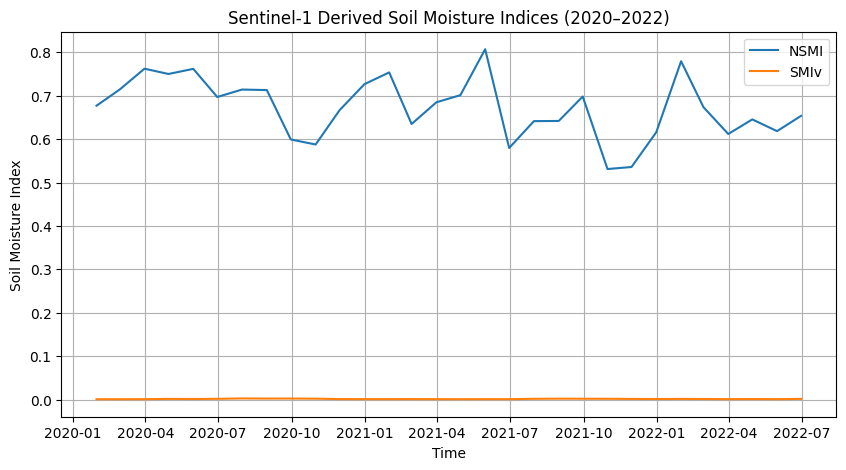

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) # set figure size

# Line Plots of indices
plt.plot(df_S2_point['time'], df_S2_point['NSMI'], label='NSMI')
plt.plot(df_S2_point['time'], df_S2_point['SMIv'], label='SMIv')

plt.title('Sentinel-1 Derived Soil Moisture Indices (2020–2022)') # Title
plt.xlabel('Time') # x-axis labe 
plt.ylabel('Soil Moisture Index') # y-axis label
plt.legend() # include legend
plt.grid(True) # add grids
plt.show()


### Extract Satellite Data Using coordinates (lon/lat) of observed data and a buffer

This code extracts Sentinel-1 soil moisture indices (NSMI and SMIv) for a small area around a specified point. It first converts the point to UTM coordinates and creates a spatial buffer, then masks the dataset to include only pixels within that buffer. The code averages the indices over the buffered area, subsets the data to the 2020–2022 period, and converts the result to a DataFrame for easy analysis and visualization.

Lon = -1.2; Lat = 9.5. 
buffer_radius = 100 m
mask = 200 m (pixels within 200 m of the point)

In [22]:
#Creating a Buffur
# 1. Define the point 
lon, lat = -1.2, 9.5  # WGS84 coordinates (degrees)

# 2. Convert to UTM (same CRS as Sentinel dataset) ---
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32630", always_xy=True)
x_center, y_center = transformer.transform(lon, lat)

# 3. Define 100 m buffer 
buffer_radius = 100  # in meters

# 4. Create a mask for all grid cells within the 1 km buffer 
# Compute distance from each grid point to the target coordinate
x, y = np.meshgrid(S2_M.x, S2_M.y)
distance = np.sqrt((x - x_center)**2 + (y - y_center)**2)

# pixels within ~200 m of the point
mask = distance <= 200  

# 5. Apply the mask to the Sentinel dataset 
# Select indices variables, then mask the spatial area saved to S2_buffer
S2_buffer = S2_M[['NSMI', 'SMIv']].where(mask)

# 6. Average over all valid pixels inside the buffer saved to S2_buffer_mean
S2_buffer_mean = S2_buffer.mean(dim=['x', 'y'], skipna=True)

# 7. Subset for 2020–2022 
S2_buffer_mean = S2_buffer_mean.sel(time=slice("2020-01-01", "2022-07-05"))

# 8. Convert to DataFrame  saved to df_buffer_S2_buffer
df_S2_buffer = S2_buffer_mean.to_dataframe().reset_index()

print(df_S2_buffer.head())

        time      NSMI      SMIv  spatial_ref
0 2020-01-31  0.640911  0.001032        32630
1 2020-02-29  0.707504  0.000856        32630
2 2020-03-31  0.693179  0.000825        32630
3 2020-04-30  0.687884  0.001196        32630
4 2020-05-31  0.656475  0.001220        32630


### Load Observed Data and Add to Extracted Satellite data

Drop all missing values and save data for regression analysis

In [23]:
# --- 1. Load the observed soil moisture data from CSV ---
# Ensure the CSV has a 'time' column or a date field that can be matched
obs = pd.read_csv("Data/soil_moisture_monthly_cd.csv")
obs = obs['SM']

df_S2_buffer["SM"] = obs

df_S2_buffer = df_S2_buffer.dropna() 
# Display the updated DataFrame with the new column

# Drop the 'spatial_ref' column from the DataFrame. Not to be included
del df_S2_buffer['spatial_ref'] 

# Save to file 
df_S2_buffer.to_csv("Data/for_regression.csv")

print(df_S2_buffer)

         time      NSMI      SMIv        SM
0  2020-01-31  0.640911  0.001032  0.094527
1  2020-02-29  0.707504  0.000856  0.091168
2  2020-03-31  0.693179  0.000825  0.117948
3  2020-04-30  0.687884  0.001196  0.156149
4  2020-05-31  0.656475  0.001220  0.143024
5  2020-06-30  0.656985  0.001751  0.211044
6  2020-07-31  0.624144  0.002062  0.255080
7  2020-08-31  0.581451  0.002017  0.230045
8  2020-09-30  0.564404  0.002192  0.248033
9  2020-10-31  0.555386  0.001789  0.231651
10 2020-11-30  0.593158  0.001391  0.110860
11 2020-12-31  0.638426  0.001178  0.096484
12 2021-01-31  0.718380  0.000890  0.092622
13 2021-02-28  0.729733  0.000917  0.090072
14 2021-03-31  0.734013  0.000890  0.087077
15 2021-04-30  0.729887  0.000835  0.199695
16 2021-05-31  0.691804  0.000929  0.198191
17 2021-06-30  0.669410  0.001545  0.269386
18 2021-07-31  0.620085  0.001947  0.244079
19 2021-08-31  0.572185  0.002294  0.152927
20 2021-09-30  0.564831  0.002157  0.118542
21 2021-10-31  0.534477  0.00200

### Select Irrigation Months and save to new datasets 

This code reads a CSV file containing SMI and observed SM, cleans and standardizes the column names, identifies and converts the time column to a proper datetime format, and extracts the month from each record. It then filters the dataset to include only the irrigation season months (November to March) and saves the filtered data to a new CSV file for further analysis.

In [24]:
# Read CSV
df = pd.read_csv("Data/for_regression.csv")

# Clean up column names (remove spaces and lowercase them)
df.columns = df.columns.str.strip().str.lower()

print("Available columns:", df.columns.tolist())

# Find the correct 'time' column (assuming it exists in some form)
if 'time' in df.columns:
    time_col = 'time'
elif 'date' in df.columns:
    time_col = 'date'
else:
    raise KeyError("No 'time' or 'date' column found in the CSV file.") # error when 'time' or 'date' is missing

# Convert to datetime
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

# Extract month number
df['month'] = df[time_col].dt.month

# Select months: November (11), December (12), January (1), February (2), March (3)
df_selected = df[df['month'].isin(irrigation_selected_months)]

# Save to new CSV
df_selected.to_csv("Data/selected_months_Nov_to_Mar.csv", index=False)


Available columns: ['unnamed: 0', 'time', 'nsmi', 'smiv', 'sm']


### Some plotting Exercises

This code creates a scatter plot comparing the NSMI or SMIv with measured soil moisture (SM). It visualizes the data points with distinct colors and edges, computes and overlays a linear best-fit line, and adds axis labels, a title, legend, and grid for clarity.

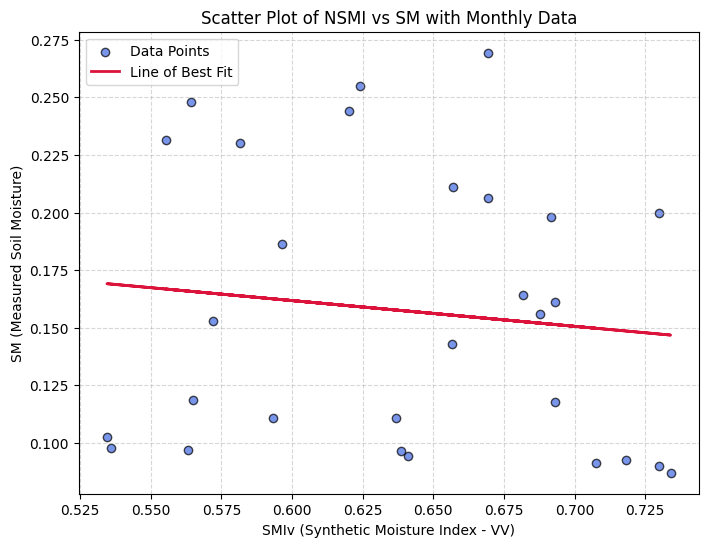

In [25]:
# Extract variables
x = df_S2_buffer['NSMI']
y = df_S2_buffer['SM']

# Create scatter plot with distinct color and edge
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='royalblue', edgecolor='black', alpha=0.7, label='Data Points')

# Compute line of best fit
m, b = np.polyfit(x, y, 1)  # linear regression
plt.plot(x, m*x + b, color='crimson', linewidth=2, label='Line of Best Fit')

# Labels and title
plt.xlabel('SMIv (Synthetic Moisture Index - VV)')
plt.ylabel('SM (Measured Soil Moisture)')
plt.title('Scatter Plot of NSMI vs SM with Monthly Data')
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

This code creates a scatter plot comparing the NSMI or SMIv with measured soil moisture (SM) for irrigation months. It visualizes the data points with distinct colors and edges, computes and overlays a linear best-fit line

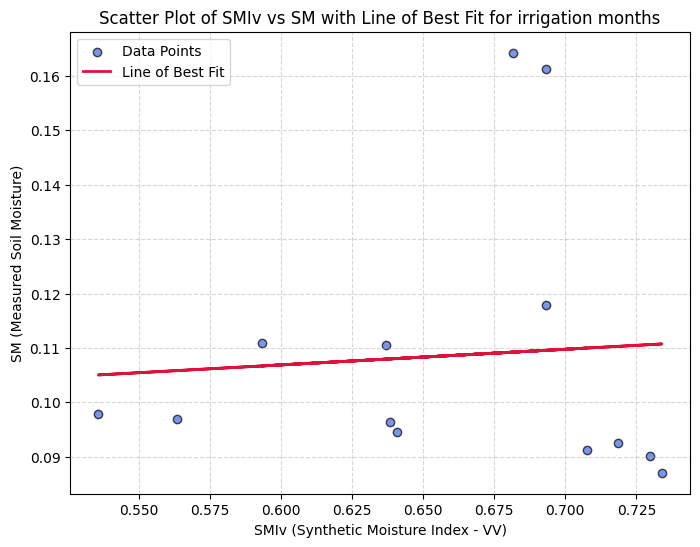

In [26]:
# Extract variables
x = df_selected['nsmi']
y = df_selected['sm']

# Create scatter plot with distinct color and edge
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='royalblue', edgecolor='black', alpha=0.7, label='Data Points')
dates = df_S2_buffer['time']

# Compute line of best fit
m, b = np.polyfit(x, y, 1)  # linear regression
plt.plot(x, m*x + b, color='crimson', linewidth=2, label='Line of Best Fit')

# Labels and title
plt.xlabel('SMIv (Synthetic Moisture Index - VV)')
plt.ylabel('SM (Measured Soil Moisture)')
plt.title('Scatter Plot of SMIv vs SM with Line of Best Fit for irrigation months')
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


This code creates a scatter plot comparing the NSMI or SMIv with measured soil moisture (SM) for irrigation months dropping rows with SM values less that 0.095. This select only rows with SM values greater than 0.095

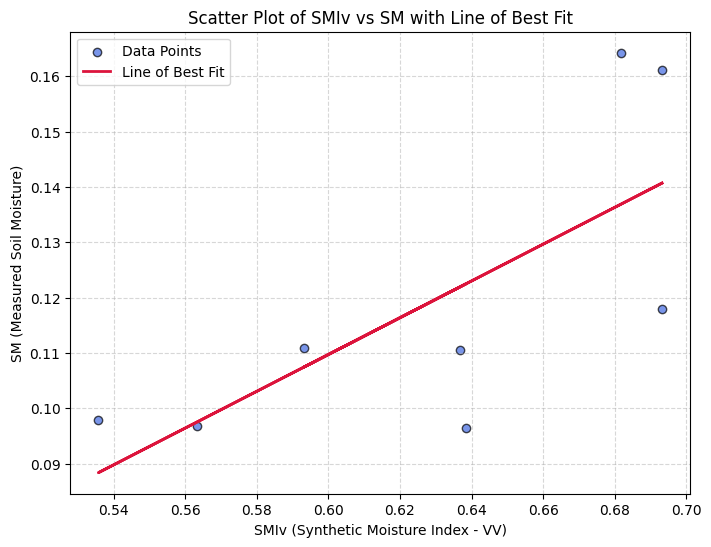

In [27]:
# Select only rows with 'sm' values greater that 0.095
df_selected = df_selected[df_selected['sm']>0.095]

x = df_selected['nsmi']
y = df_selected['sm']

# Create scatter plot with distinct color and edge
plt.figure(figsize=(8,6))
plt.scatter(x, y, color='royalblue', edgecolor='black', alpha=0.7, label='Data Points')
dates = df_S2_buffer['time']

# Compute line of best fit
m, b = np.polyfit(x, y, 1)  # linear regression
plt.plot(x, m*x + b, color='crimson', linewidth=2, label='Line of Best Fit')

# Labels and title
plt.xlabel('SMIv (Synthetic Moisture Index - VV)')
plt.ylabel('SM (Measured Soil Moisture)')
plt.title('Scatter Plot of SMIv vs SM with Line of Best Fit')
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## REGRESSION ANALYSIS
### Linear Polynomial Regression

In this section, a linear polynomial regression approach is applied to explore the relationship between the observed soil moisture (SM) and the soil moisture indices (SMI and nSMI) derived from Sentinel-2 imagery for irrigation months.
The objective is to establish a simple yet meaningful statistical model that captures how variations in these satellite-derived indices correspond to changes in ground-measured soil moisture.

By fitting a linear equation of the form:

    𝑆𝑀 = a×𝑆𝑀𝐼+𝑏


We can estimate the slope (a) and intercept (b) that best represent this relationship.
Once the relationship is examined and accepted with the objective function, like R-squared, it can be used to predict soil moisture values directly from the remotely sensed indices for locations or times where in-situ measurements are unavailable.

In [28]:
# x and y are your variables, e.g.:
x = df_selected['nsmi']
x1 = df_selected['smiv']
y = df_selected['sm']

# Compute regression coefficients
a, b = np.polyfit(x, y, 1)  # slope (a), intercept (b)
a1, b1 = np.polyfit(x1, y, 1)  # slope (a), intercept (b)

print(f"Slope (a): {a:.4f}")
print(f"Intercept (b): {b:.4f}")

print(f"Slope (a1): {a1:.4f}")
print(f"Intercept (b1): {b1:.4f}")

# Predict y values
y_pred = a * x + b
y_pred1 = a1 * x1 + b1

# Compute R²
r = np.corrcoef(x, y)[0, 1]
r1 = np.corrcoef(x1, y)[0, 1]

r2 = r**2
r21 = r1**2
print(f"NSMI R²: {r2:.4f}")
print(f"SMIv R²: {r21:.4f}")


Slope (a): 0.3323
Intercept (b): -0.0897
Slope (a1): -57.5411
Intercept (b1): 0.1855
NSMI R²: 0.5202
SMIv R²: 0.4910


### Substituting the coefficients into the formula

Using `a=0.2803` and `b=-0.0633` for NSMI
and `a=-59.7852` and `b=0.1811` for SMIv, we compute SM as follows:
$$
SM = a \times SMI + b
$$

#### Substituting for NSMI
Input the a and b in the SM equation to estimate soil moisture from NSMI index

In [29]:
a =  0.2803 # slope for NSMI
b = -0.0633 # Intercept (from your regression model with NSMI)
SoilMoisture_NSMI = a*S1_mask['NSMI']+b

#### Substituting for SMIv
Input the a and b in the SM equation to estimate soil moisture from SMIv index

In [30]:
a = -59.7852 # slope for SMIv
b = 0.1811 # Intercept (from your regression model with SMIv)
SoilMoisture_SMIv = a*S1_mask['SMIv']+b

#### Adding Derived Soil Moisture to the data array for Bontanga Irrigation Scheme

In [31]:
### Add new Soil moisture calculated to the xarray
S1_mask['SoilMoisture_NSMI'] = SoilMoisture_NSMI 
S1_mask['SoilMoisture_SMIv'] = SoilMoisture_SMIv 

S1_mask

<xarray.Dataset> Size: 994MB
Dimensions:            (time: 209, y: 574, x: 259)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2020-01-05T18:19:21.943758 ....
  * y                  (y) float64 5kB 1.064e+06 1.064e+06 ... 1.058e+06
  * x                  (x) float64 2kB 7.146e+05 7.147e+05 ... 7.172e+05
    spatial_ref        int32 4B 32630
Data variables:
    vv                 (time, y, x) float32 124MB nan nan nan ... nan nan nan
    vh                 (time, y, x) float32 124MB nan nan nan ... nan nan nan
    vv_filtered        (time, y, x) float32 124MB nan nan nan ... nan nan nan
    vh_filtered        (time, y, x) float32 124MB nan nan nan ... nan nan nan
    NSMI               (time, y, x) float32 124MB nan nan nan ... nan nan nan
    SMIv               (time, y, x) float32 124MB nan nan nan ... nan nan nan
    SoilMoisture_NSMI  (time, y, x) float32 124MB nan nan nan ... nan nan nan
    SoilMoisture_SMIv  (time, y, x) float32 124MB nan nan nan ... nan nan nan
Attributes:
    crs:           EPSG:32630
    grid_mapping:  spatial_ref

### Visualization of Soil Moisture from NSMI and SMIv 

A quick visualization of the soil moisture derived for NSMI and SMIv

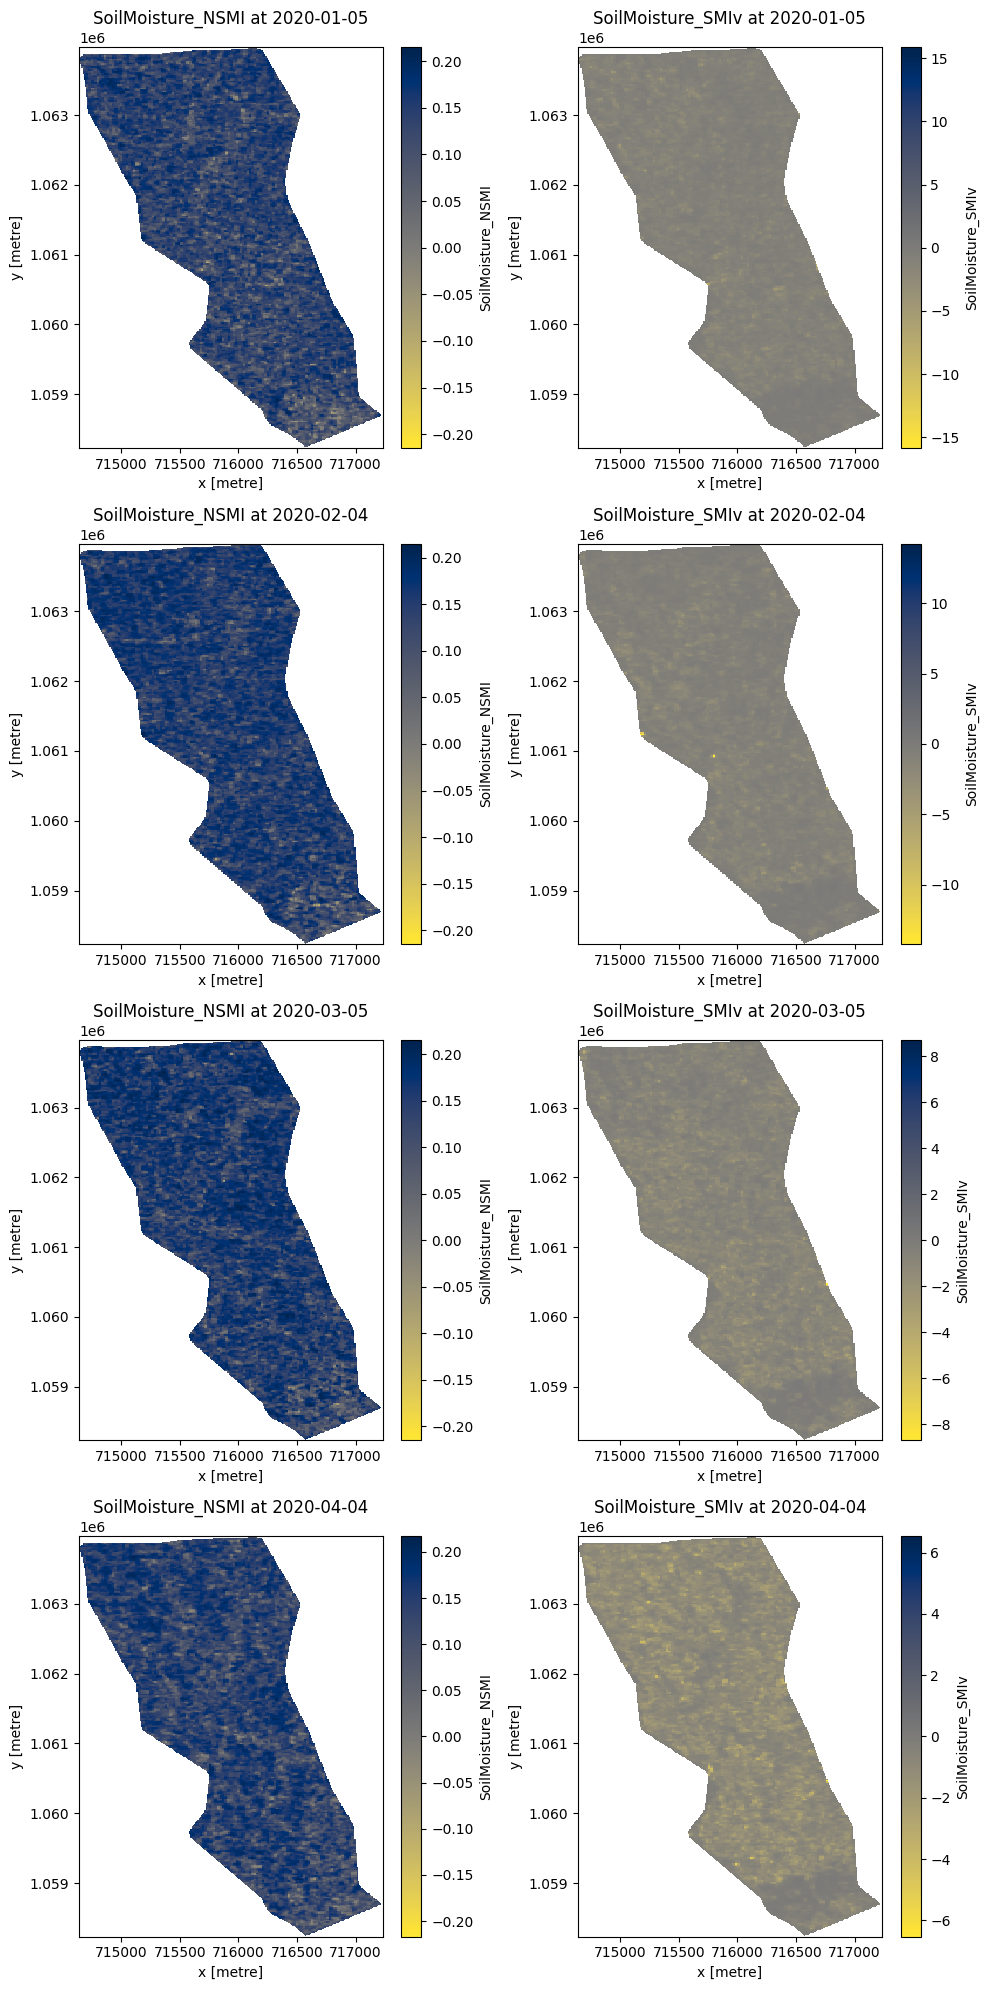

In [32]:
# Time steps to visualize 
time_indices = [0, 5, 10, 15]  

# Create a 4x2 grid of subplots (4 timesteps, 2 maps per timestep)
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

for i, t in enumerate(time_indices):
    # Convert time to readable date format
    date = pd.to_datetime(S1_mask.time[t].values).strftime('%Y-%m-%d')
    # Plot SoilMoisture from NSMI
    S1_mask["SoilMoisture_NSMI"].isel(time=t).plot(ax=axes[i, 0], cmap='cividis_r')
    axes[i, 0].set_title(f"SoilMoisture_NSMI at {date}")
    # Plot SoilMoisture from SMIv
    S1_mask["SoilMoisture_SMIv"].isel(time=t).plot(ax=axes[i, 1], cmap='cividis_r')
    axes[i, 1].set_title(f"SoilMoisture_SMIv at {date}")
# Adjust spacing between plots
plt.tight_layout()
plt.show() # display plot

### Calculate yearly soil moisture from SoilMoisture_NSMI and Yearly SoilMoisture_SMIv

Resamples each variable by year (1Y) and averages over time.


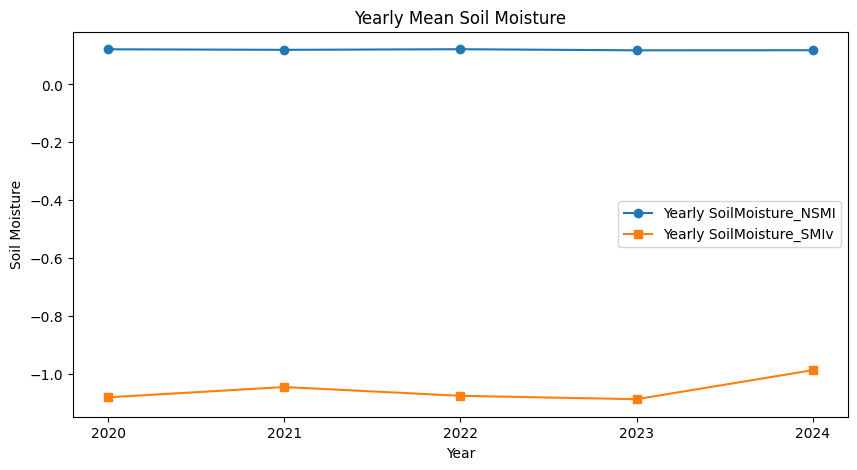

In [33]:
# Calculate yearly soil moisture
yearly_meanSoilMoisture_NSMI = S1_mask["SoilMoisture_NSMI"].resample(time="1Y").mean(dim="time")
yearly_meanSoilMoisture_SMIv = S1_mask["SoilMoisture_SMIv"].resample(time="1Y").mean(dim="time")

# Create figure
plt.figure(figsize=(10, 5))

# Plot the time series
plt.plot(yearly_meanSoilMoisture_NSMI.mean(dim=('x', 'y')), marker='o', 
         linestyle='-', label="Yearly SoilMoisture_NSMI")
plt.plot(yearly_meanSoilMoisture_SMIv.mean(dim=('x', 'y')), marker='s', 
         linestyle='-', label="Yearly SoilMoisture_SMIv")

# Set title and labels
plt.title("Yearly Mean Soil Moisture")
plt.xlabel("Year")
plt.ylabel("Soil Moisture")

# Set x-axis ticks and labels for 2020-2024
years = ["2020", "2021", "2022", "2023", "2024"]
plt.xticks(ticks=np.arange(len(years)), labels=years)

# Add legend and show plot
plt.legend()
plt.show()


### Monthly Averages 

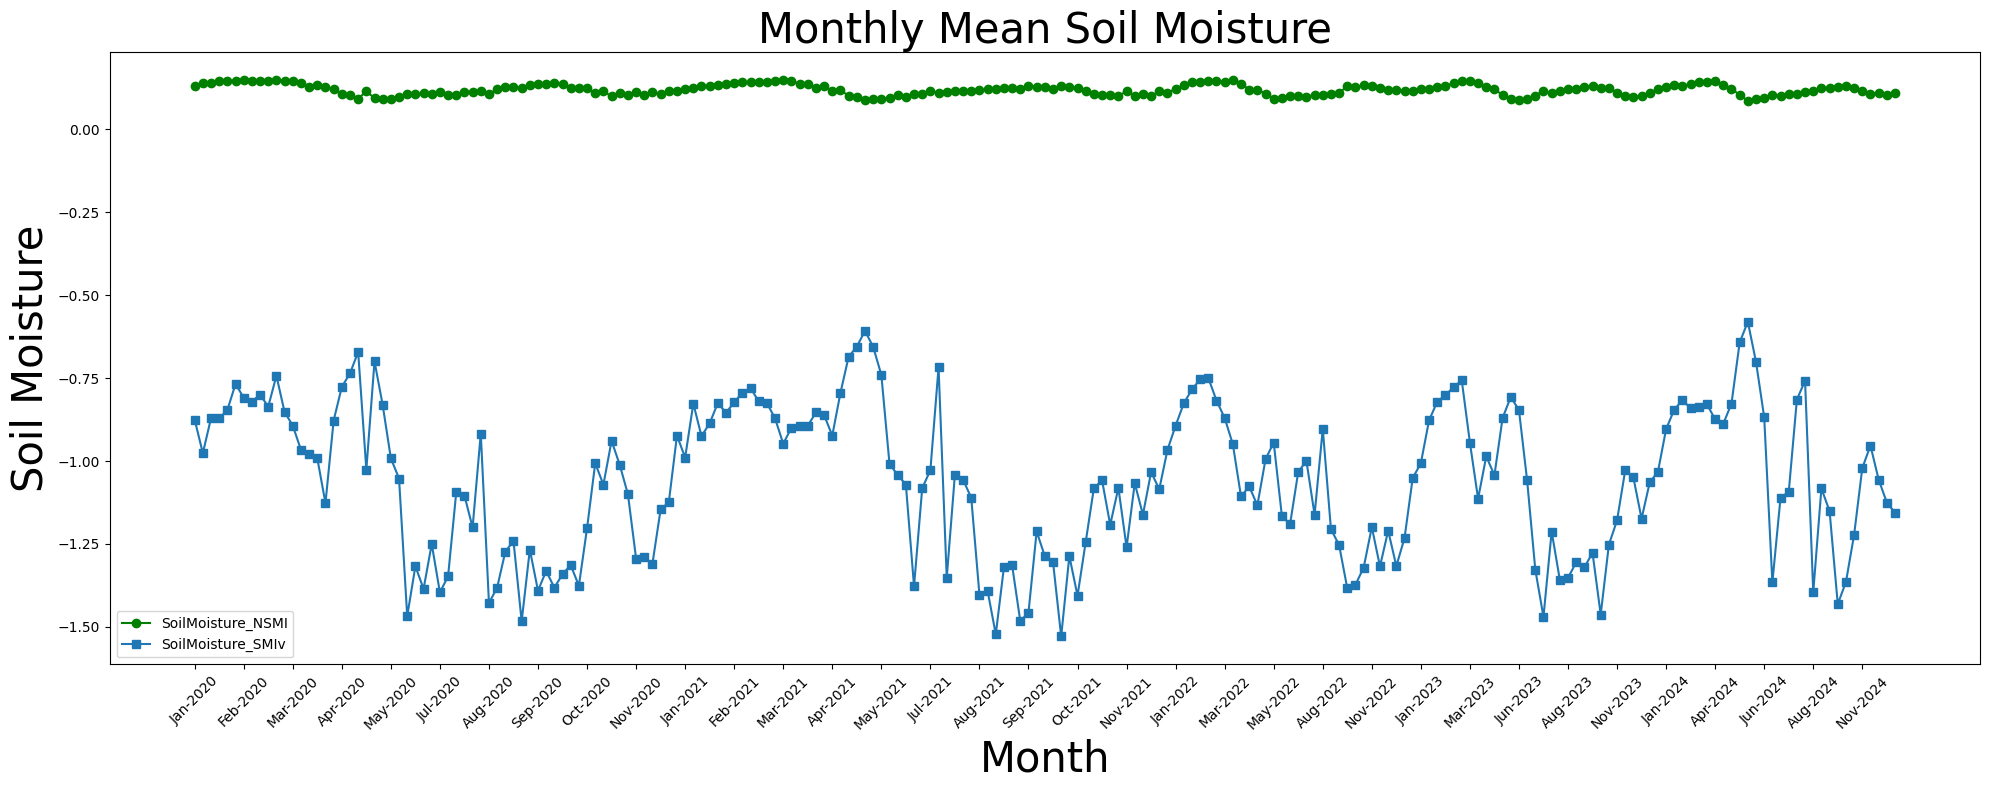

In [34]:
# Compute monthly mean over spatial dimensions
nsmi_monthly = S1_mask["SoilMoisture_NSMI"].mean(dim=("x", "y"))
smiv_monthly = S1_mask["SoilMoisture_SMIv"].mean(dim=("x", "y"))

# Generate x-axis labels in "Mon-YYYY" format
months_labels = pd.to_datetime(nsmi_monthly.time.values).strftime('%b-%Y')

# Plot
plt.figure(figsize=(20, 8))
plt.plot(nsmi_monthly, marker='o', linestyle='-', color='g', label="SoilMoisture_NSMI")
plt.plot(smiv_monthly, marker='s', linestyle='-', label="SoilMoisture_SMIv")

plt.title("Monthly Mean Soil Moisture", fontsize=30)
plt.xlabel("Month", fontsize=30)
plt.ylabel("Soil Moisture", fontsize=30)

# Only show every 3rd month label (adjust step as needed)
step = 6   # change to 6 or 12 for yearly labels
plt.xticks(
    ticks=range(0, len(months_labels), step),
    labels=months_labels[::step],
    rotation=45,
)

plt.legend()
plt.tight_layout()
plt.show()